# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [Rémi Offner](https://github.com/remsitoo)
- [Téis Matencio](https://github.com/Teis-03)

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

Xtrain :  [[-0.72221141  2.00447087]
 [-0.92467912  0.48366928]
 [-0.76602281  0.79432891]
 [-0.07328948  0.96992915]
 [-1.39291198  0.99969709]
 [-0.20223339  1.35033191]
 [ 0.48173767  0.98441858]
 [-1.86551212  1.54773159]
 [-0.15246873  0.92248969]
 [ 0.38635649  0.36633672]]
ClassTrain :  [2. 2. 2. 2. 1. 2. 2. 1. 2. 2.]
Xtest :  [[ 0.54837733  1.2213453 ]
 [-0.51618236  1.56239592]
 [-0.92877833  0.92107217]
 [ 0.07000405  0.61976747]
 [ 0.26702843  1.10944064]
 [-0.57664073  1.02574324]
 [-0.57199822  0.97485442]
 [ 0.08591043  1.44378449]
 [ 0.58396426  0.67384452]
 [-1.06711928  2.74219239]]
Class_test_1 :  [[ 1.         -1.06711928  2.74219239]
 [ 1.         -0.52493625  2.29796093]
 [ 1.         -1.23658249  0.82315436]
 [ 1.         -0.31374814  2.49300606]
 [ 1.         -0.0673953   1.87508168]
 [ 1.         -1.47557179  2.13126285]
 [ 1.         -0.76332067  2.37500358]
 [ 1.         -0.96320813  2.51852029]
 [ 1.         -0.84540692  2.54204915]
 [ 1.         -0.51545336 

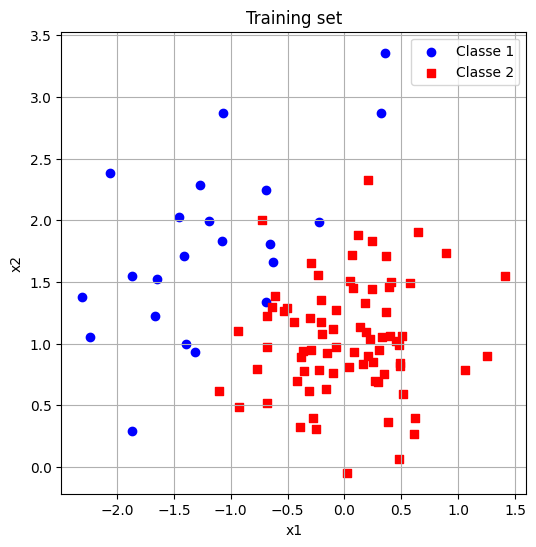

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# load the training set
train = np.loadtxt('data/synth_train.txt')
class_train = train[:,0]
x_train = train[:,1:]
print('Xtrain : ', x_train[:10])
print('ClassTrain : ', class_train[:10])
N_train = train.shape[0]

# load the test set
test = np.loadtxt('data/synth_test.txt')
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
class_test = test[:,0]
x_test = test[:,1:]
print('Xtest : ', x_test[:10])
print('Class_test_1 : ', class_test_1)
N_test = test.shape[0]


# Separating class1 and class2
x_train_class1 = x_train[class_train == 1]
x_train_class2 = x_train[class_train == 2]

# Displaying the training set
plt.figure(figsize=(6,6))
plt.scatter(x_train_class1[:,0], x_train_class1[:,1], c='blue', marker='o', label='Classe 1')
plt.scatter(x_train_class2[:,0], x_train_class2[:,1], c='red', marker='s', label='Classe 2')

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Training set")
plt.legend()
plt.grid(True)
plt.show()

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


```python
import numpy as np
import bottleneck as bn

# Create a random array
arr = np.random.rand(10)
N = 3  # Number of smallest elements to retrieve

# Using np.argsort() to get indices of the first N elements
sorted_indices = np.argsort(arr)[:N]

# Using bottleneck.argpartition() to get the first N smallest indices
partitioned_indices = bn.argpartition(arr, N)[:N]

# Display the results
print("Original array:", arr)
print("Indices using np.argsort:", sorted_indices)
print("First N elements using np.argsort:", arr[sorted_indices])

print("Indices using bottleneck.argpartition:", partitioned_indices)
print("First N elements using bottleneck.argpartition:", arr[partitioned_indices])

are_equal = set(arr[sorted_indices]) == set(arr[partitioned_indices])
print(are_equal)
```


**Answer:**

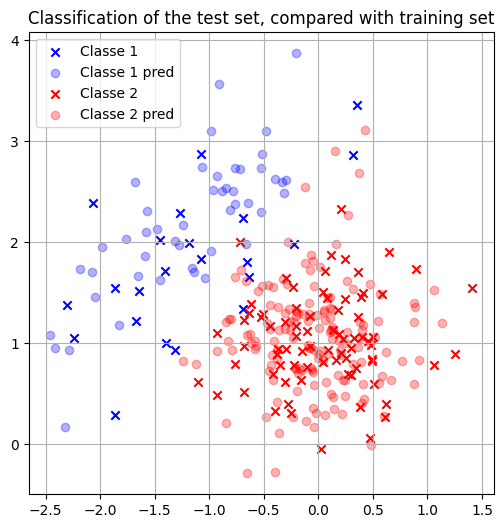

In [ ]:
def KNN_algorithm (x_train, x_test, n_neighbours) :
    x_test_dist = []
    for i in range(N_test): # computing the distance between the i point of the test set, with all the point of the train set
        dist = []
        for j in range(N_train):
            dist.append(np.linalg.norm(x_test[i] - x_train[j]))
        x_test_dist.append(dist)

    x_test_dist = np.array(x_test_dist)
    x_test_dist_ordered_id = np.argsort(x_test_dist) # id list of the ordered distances

    # Getting the labels of the n closest neighbour for each test row
    x_test_neighbours_label = []
    for i in range(N_test) :
        id = x_test_dist_ordered_id[i][:n_neighbours] # the ids of the n closest neighbours of i test point
        labels = class_train[id]# the labels of the n closest neighbours of i test point
        x_test_neighbours_label.append(labels)

    x_test_neighbours_label = np.array(x_test_neighbours_label).astype(np.int64)

    class_pred = []
    for i in range(N_test):
        t = np.bincount(x_test_neighbours_label[i]) # counting occurences of class 1 and class 2 in closest neighbours of the i test point
        pred = np.argmax(t) # getting the index (= class) of the maximum of occurences
        class_pred.append(pred)

    class_pred = [int(x) for x in class_pred] # converting it in a list

    return class_pred

    #print(np.unique(class_pred, return_counts = True))

    #print('prediction : ', class_pred)


# Testing the algorithm
test_class_pred = np.array(KNN_algorithm(x_train, x_test, 10))
x_test_pred_1 = test[test_class_pred == 1][:, 1:]
x_test_pred_2 = test[test_class_pred == 2][:, 1:]



# Displaying the training set and prediction of test set
plt.figure(figsize=(6,6))
plt.scatter(x_train_class1[:,0], x_train_class1[:,1], c='blue', marker='x', label='Classe 1')
plt.scatter(x_test_pred_1[:,0], x_test_pred_1[:,1], c='blue', marker='o', alpha=0.3, label='Classe 1 pred')
plt.scatter(x_train_class2[:,0], x_train_class2[:,1], c='red', marker='x', label='Classe 2')
plt.scatter(x_test_pred_2[:,0], x_test_pred_2[:,1], c='red', marker='o', alpha=0.3, label='Classe 2 pred')


plt.title("Classification of the test set, compared with training set")
plt.legend()
plt.grid(True)
plt.show()

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

3
Error rates: [np.float64(0.065), np.float64(0.06), np.float64(0.045), np.float64(0.05), np.float64(0.06), np.float64(0.055), np.float64(0.07), np.float64(0.07), np.float64(0.075), np.float64(0.075), np.float64(0.09), np.float64(0.075), np.float64(0.08), np.float64(0.075), np.float64(0.075), np.float64(0.075), np.float64(0.08), np.float64(0.08), np.float64(0.08), np.float64(0.08)]


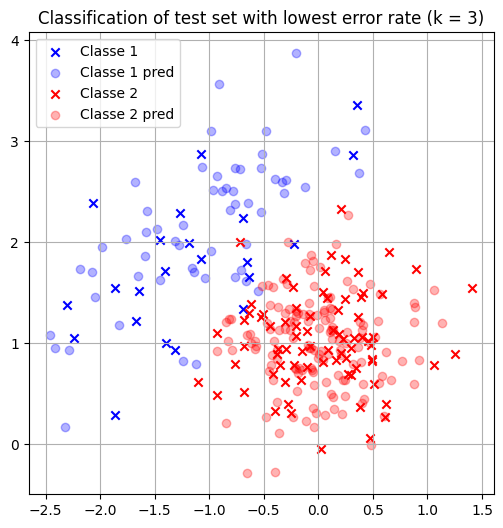

In [12]:
error_rates = []
for k in range(1, 21):
    class_pred = KNN_algorithm(x_train, x_test, k)
    errors = []
    for i in range(N_test) :
        error = np.abs(class_pred[i] - class_test[i])   # évaluation de la prédiction
        errors.append(error)

    #print('erreurs : ', errors)

    error_rates.append(np.mean(errors))

best_k = np.argmin(error_rates) + 1
print(best_k)

print("Error rates:", error_rates)

best_class_pred = np.array(KNN_algorithm(x_train, x_test, best_k))
x_best_pred_1 = test[best_class_pred == 1][:, 1:]
x_best_pred_2 = test[best_class_pred == 2][:, 1:]

# Displaying the training set and prediction of test set
plt.figure(figsize=(6,6))
plt.scatter(x_train_class1[:,0], x_train_class1[:,1], c='blue', marker='x', label='Classe 1')
plt.scatter(x_best_pred_1[:,0], x_best_pred_1[:,1], c='blue', marker='o', alpha=0.3, label='Classe 1 pred')
plt.scatter(x_train_class2[:,0], x_train_class2[:,1], c='red', marker='x', label='Classe 2')
plt.scatter(x_best_pred_2[:,0], x_best_pred_2[:,1], c='red', marker='o', alpha=0.3, label='Classe 2 pred')


plt.title(f"Classification of test set with lowest error rate (k = {best_k})")
plt.legend()
plt.grid(True)
plt.show()


4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

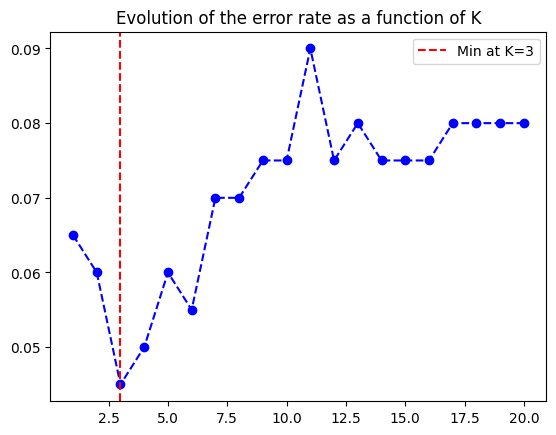

In [10]:
K = range(1,21)

# Displaying the error rate evolution as a function of K
plt.figure()
plt.plot(K, error_rates, "--o", color="blue")
plt.axvline(x=best_k, color="red", linestyle="--", label=f"Min at K={best_k}")
plt.title('Evolution of the error rate as a function of K')
plt.legend()
plt.show()

The K with the lowest error rate is 3. Thus, it seems to be the optimal number of neighbour to train the algorithm. 
We can also observe that the error rate get to its maximum for K = 1, and then stabilize from K = 17 to 20 at 0.8.

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

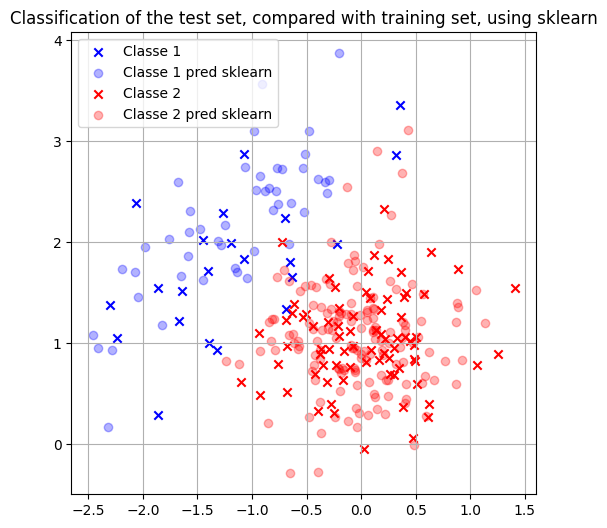

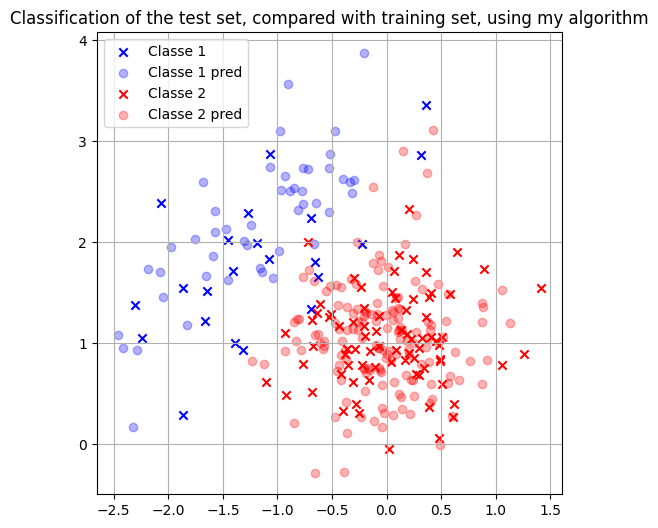

In [23]:
from sklearn.neighbors import KNeighborsClassifier
import timeit

# Training the sklearn KNN model
KNN = KNeighborsClassifier(n_neighbors= 10)
KNN.fit(x_train, class_train)

# using the sklearn KNN model to predict the class
sklearn_class_pred = KNN.predict(x_test)
x_test_pred_sklearn_1 = test[sklearn_class_pred == 1][:, 1:]
x_test_pred_sklearn_2 = test[sklearn_class_pred == 2][:, 1:]


# Displaying the training set and prediction of test set using sklearn
plt.figure(figsize=(6,6))
plt.scatter(x_train_class1[:,0], x_train_class1[:,1], c='blue', marker='x', label='Classe 1')
plt.scatter(x_test_pred_sklearn_1[:,0], x_test_pred_1[:,1], c='blue', marker='o', alpha=0.3, label='Classe 1 pred sklearn')
plt.scatter(x_train_class2[:,0], x_train_class2[:,1], c='red', marker='x', label='Classe 2')
plt.scatter(x_test_pred_sklearn_2[:,0], x_test_pred_2[:,1], c='red', marker='o', alpha=0.3, label='Classe 2 pred sklearn')


plt.title("Classification of the test set, compared with training set, using sklearn")
plt.legend()
plt.grid(True)
plt.show()




# Using my algorithm
test_class_pred = np.array(KNN_algorithm(x_train, x_test, 10))
x_test_pred_1 = test[test_class_pred == 1][:, 1:]
x_test_pred_2 = test[test_class_pred == 2][:, 1:]

# Displaying the training set and prediction of test set using my algorithm
plt.figure(figsize=(6,6))
plt.scatter(x_train_class1[:,0], x_train_class1[:,1], c='blue', marker='x', label='Classe 1')
plt.scatter(x_test_pred_1[:,0], x_test_pred_1[:,1], c='blue', marker='o', alpha=0.3, label='Classe 1 pred')
plt.scatter(x_train_class2[:,0], x_train_class2[:,1], c='red', marker='x', label='Classe 2')
plt.scatter(x_test_pred_2[:,0], x_test_pred_2[:,1], c='red', marker='o', alpha=0.3, label='Classe 2 pred')


plt.title("Classification of the test set, compared with training set, using my algorithm")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Comparing the runtime of using both algorithm

time_myAlgorithm = timeit.timeit("KNN_algorithm(x_train, x_test, 10)", globals=globals(), number=10)
print('My algorithm has a runtime of : ', time_myAlgorithm)

time_sklearn = timeit.timeit("KNN.predict(x_test)", globals=globals(), number=10)
print('Sklearn algorithm has a runtime of : ', time_sklearn)

print(time_myAlgorithm/time_sklearn)

My algorithm has a runtime of :  1.5489056999999775
Sklearn algorithm has a runtime of :  0.023109799999929237
67.0237604827701


My algorithm is almost 70 longer to run than the sklearn one.

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

In [45]:
from sklearn.model_selection import train_test_split

data = np.loadtxt('data/wdbc12.data.txt', delimiter=',')
#print(data[:2])
X = data[:, 2:]   # every column apart from the two first
y = data[:, 1]    # second column = classe

# Division train/test 80%/20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(y_train[:10])

N_test_wdbc = np.shape(y_test)[0]
print('n_test', N_test_wdbc)

# training the sklearn model
KNNbis = KNeighborsClassifier(n_neighbors= 10)
KNNbis.fit(X_train, y_train)

# using the sklearn KNN model to predict the class
class_pred_wdbc = KNNbis.predict(X_test)
print('class_pred : ', class_pred_wdbc)

# computing the error rate
errors = []
for i in range(N_test_wdbc) :
    error = np.abs(class_pred_wdbc[i] - y_test[i])   # prediction evaluation
    errors.append(error)

error_rate = np.mean(errors)

print('error_rate : ', error_rate)


[2. 1. 2. 2. 2. 1. 2. 2. 2. 1.]
n_test 114
class_pred :  [2. 1. 1. 2. 2. 1. 1. 1. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2. 2. 1. 1. 2. 1. 2.
 2. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2. 2. 1. 2. 1. 2. 2. 1. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 1. 1. 2. 2. 2. 1. 1. 2. 2. 1. 1.
 2. 1. 2. 2. 2. 1. 2. 2. 1. 2. 2. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 1. 1. 2. 1. 1. 2. 1. 1. 2. 2. 2. 1. 2. 2. 1. 2. 2. 1.]
error_rate :  0.02631578947368421


## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [ ]:
!cd example_cy && python setup.py build_ext --inplace

In [ ]:
import example_cy.example_cy.helloworld as toy

toy.printhello()

which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [ ]:
# your code

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [ ]:
# your code

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [ ]:
# your code

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [ ]:
# your code

2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [ ]:
# your code